In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, LinearSegmentedColormap, SymLogNorm, ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d
import sys
import os
import warnings

helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

# get viridis colormap
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='black')
# set dpi to 200
mpl.rcParams['figure.dpi'] = 200

In [2]:
# various CO2 phase diagarams from different sources
tco2_mar2, pco2_mar2 = np.loadtxt("../../FFP-Exomoons/plot_pt/co2_pt3.dat").T
tco2_mar6, pco2_mar6 = np.loadtxt("../../FFP-Exomoons/plot_pt/co2_pt6.dat").T

i_exclude = 4

appended_pco2 = np.append(pco2_mar2, pco2_mar6[:-i_exclude]*1e-5)
# sort, save sorting mask and sort tco2 similarly
mask = np.argsort(appended_pco2)
appended_pco2 = appended_pco2[mask]
appended_tco2 = np.append(tco2_mar2, tco2_mar6[:-i_exclude])[mask]

interpolated_tco2 = interp1d(np.log10(appended_pco2), appended_tco2, kind='linear', bounds_error=False, fill_value=(appended_tco2[0], appended_tco2[-1]))

# H2 phase diagram
th2_pt, ph2_pt = np.loadtxt("../../FFP-Exomoons/plot_pt/h2_pt.dat").T

# water data
T_freeze = 273.15 # K
T_boil = np.array([50, 100, 180, 310]) # deg C for P = [0.1, 1, 10, 100] bar
T_boil = T_boil + T_freeze # K
P_boil = np.array([0.1, 1, 10, 100]) # bar

interpolated_th2 = interp1d(np.log10(ph2_pt), th2_pt, kind='linear', bounds_error=False, fill_value=(th2_pt[0], th2_pt[-1]))

In [3]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7]) # surface pressure in dyn/cm^2
Tints = np.array([100, 150, 200, 250, 300, 350]) # internal temperature in K

CplusOs = np.array([1e-3, 1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0])
CtoOs = np.array([0.1, 0.3, 0.59, 1.0, 1.2])

In [87]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None):
    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'Earth_P0={format_e_nums(loop_over)}_Tint={Tint}_NoCond_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'Earth_P0={format_e_nums(P0)}_Tint={loop_over}_NoCond_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'Earth_P0={format_e_nums(P0)}_Tint={Tint}_NoCond_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'Earth_P0={format_e_nums(P0)}_Tint={Tint}_NoCond_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}'
    else:
        raise ValueError('Invalid loop_over value')

folder = '../output/EqChem/'

def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0):
        
    inds = []
    PTs = []
    nHtots = []
    data = []
    atoms = []
    mols = []
    supersats = []
    dusts = []
    mus = []
    convergence = []
    n_iter = []

    for i, loop_over in enumerate(loop_overs):
        name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO])
        #print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        conv = True
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    if d[-1,2] != 1e-1: # if pressure is not 0.1 dyn/cm^2 (=1e-7 bar), then the simulation did not converge
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                        j -= 1
                        break
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                    j -= 1
                    break

        if i == 0:
            dimension = np.genfromtxt(path.format(var=j), dtype=int,  max_rows=1, skip_header=1)
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)
        
        if j == -1:
            d = np.zeros_like(d)
            d[:,:] = np.nan

            mu = np.zeros_like(mu)
            mu[:] = np.nan

            j = np.nan
            
        else:
            d = np.loadtxt(path.format(var=j), skiprows=3)
            data.append(d)

            try:
                mu = path[:-21] + f'vertical_mix_{j}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
            except FileNotFoundError:
                print('WARNING: ' + path[:-21] + f'vertical_mix_{j}.dat' + ' not found')
                mu = path[:-21] + f'vertical_mix_{j-1}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
                conv = False

        PTs.append(np.array([d[:,2]*1e-6, d[:,0]]).T) # convert pressure from dyn/cm^2 to bar
        nHtots.append(d[:,1])
        atoms.append(d[:,3:4+n_elem])
        mols.append(d[:,4+n_elem:4+n_elem+n_mol])
        supersats.append(d[:,4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        dusts.append(d[:,4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        inds.append(i)

        mus.append(mu)

        convergence.append(conv)
        n_iter.append(j)

    return np.array(name), np.array(inds), np.array(PTs), np.array(nHtots), np.array(data), np.array(atoms), np.array(mols), np.array(supersats), np.array(dusts), np.array(mus), np.array(convergence), np.array(n_iter)

def convert(data, atoms, mols, dusts, nHtots):
    n_tots = []
    for i in range(len(data)):
        n_tot = 10**data[i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        n_tots.append(n_tot[:,None])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(atoms):
        atom = 10**atom
        atoms[i] = atom / n_tots[i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(mols):
        mol = 10**mol
        mols[i] = mol / n_tots[i]

    #for i in range(len(supersats)):
    #    supersats[i] = 10**supersats[i]

    for i in range(len(dusts)):
        dusts[i] = 10**(dusts[i]) * nHtots[i][:,None] / n_tots[i]

    return n_tots, atoms, mols, dusts

In [93]:
def get_BOA_TOA(i_temp, i_press):
    # read TOA and BOA temps for certain T and P with varying h2o and co2
    print('T =', Tints[i_temp], 'K , P =', P0s[i_press]/1e6, 'bar')

    BOAmatrix = np.empty((len(CplusOs), len(CtoOs)))
    BOAmatrix[:] = np.nan
    TOAmatrix = BOAmatrix.copy()

    loop_overs = CplusOs

    for i_CtoO in np.arange(len(CtoOs)):
        name, inds, PTs, nHtots, data, atoms, mols, supersats, dusts, mus, conv, n_iter = extract_data(loop_overs, i_P0=i_press, i_Tint=i_temp, i_CtoO=i_CtoO)
        #name, inds, PTs, nHtots, data, atoms, mols, supersats, dusts, mus, conv = extract_data(loop_overs, i_P0=i_press, i_Tint=i_temp, i_CtoO=i_CtoO)
        
        BOAmatrix[conv, i_CtoO] = [PTs[i][0, 1] for i in range(len(PTs)) if conv[i]]
        TOAmatrix[conv, i_CtoO] = [PTs[i][-1, 1] for i in range(len(PTs)) if conv[i]]
        #BOAmatrix[:, i_CtoO] = n_iter

    return BOAmatrix, TOAmatrix


def plot_BOA(BOAmatrix, vmin=100, vmax=1300, display_text=False):

    # log scale for colormap
    boa_vmin = np.log10(vmin)
    boa_vmax = np.log10(vmax)

    # Define the color segments with smooth transitions
    colors = [
        (boa_vmin, "blue"),
        (np.log10(T_freeze-0.5), "lightblue"),
        (np.log10(T_freeze+0.5), "green"),
        # (np.log10((T_freeze+T_boil[i_press+1])/2), "green"),
        (np.log10(T_boil[i_press+1]-0.5), "lightgreen"),
        (np.log10(T_boil[i_press+1]+0.5), "darkorange"),
        (boa_vmax, "white")
    ]

    # Normalize the position values to be within [0, 1]
    positions = [(val - boa_vmin) / (boa_vmax - boa_vmin) for val, _ in colors]
    color_vals = [color for _, color in colors]

    # Create the custom colormap with smooth transitions
    boa_cmap = LinearSegmentedColormap.from_list("boa", list(zip(positions, color_vals)))
    boa_cmap.set_bad(color='black')

    boa_norm = LogNorm(vmin=10**boa_vmin, vmax=10**boa_vmax)

    #ticks_label = np.array([150, 200, T_freeze, 300, T_boil[i_press+1], 400, 600, 800, 1000, 1300])
    ticks_label = np.array([100, 200, 300, 400, 600, 800, 1000, 1300])
    ticks_loc = ticks_label
    ticks_label = [f"{t:.0f}" for t in ticks_label]
    #ticks_label[2] = ""
    #ticks_label[4] = ""

    boa_im = plt.imshow(BOAmatrix, origin='lower', aspect='auto', cmap=boa_cmap, norm=boa_norm)
    cbar = plt.colorbar(boa_im, label="Temperature [K]", ticks=[])
    cbar.set_ticks(ticks_loc)
    cbar.set_ticklabels(ticks_label)
    plt.xticks(np.arange(len(CtoOs)), CtoOs)
    plt.yticks(np.arange(len(CplusOs)), [f'{np.log10(CplusO):.2g}' for CplusO in CplusOs])
    plt.xlabel("C/O")
    plt.ylabel("log(C+O / (C+O+H))")
    plt.title(r"$\overline{T}_{BOA} = $" + f"{np.nanmean(BOAmatrix):.0f} K at " + r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar")
    plt.tight_layout()

    if display_text:
        for (j,i),label in np.ndenumerate(BOAmatrix):
            plt.text(i,j,f'{label:.0f}',ha='center',va='center')

    return plt.gca()

def plot_TOA(TOAmatrix, vmin=15, vmax=200, cbar_ticks=[20, 50, 100, 200], display_text=False):
    
    plt.imshow(TOAmatrix, cmap=cmap, origin='lower', aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(cmap=cmap, label="Temperature [K]")
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
    plt.xticks(np.arange(len(CtoOs)), CtoOs)
    plt.yticks(np.arange(len(CplusOs)), [f'{np.log10(CplusO):g}' for CplusO in CplusOs])
    plt.xlabel("C/O")
    plt.ylabel("log(C+O / (C+O+H))")
    plt.title(r"$\overline{T}_{TOA} = $" + f"{np.nanmean(TOAmatrix):.0f} K at " + r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar")
    plt.tight_layout()

    if display_text:
        for (j,i),label in np.ndenumerate(TOAmatrix):
            plt.text(i,j,f'{label:.0f}',ha='center',va='center')

    return plt.gca()

T = 250 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=250_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e7_Tint=250_NoCond_CplusO=1e0_CtoO=1.2!
305.776 1100.54


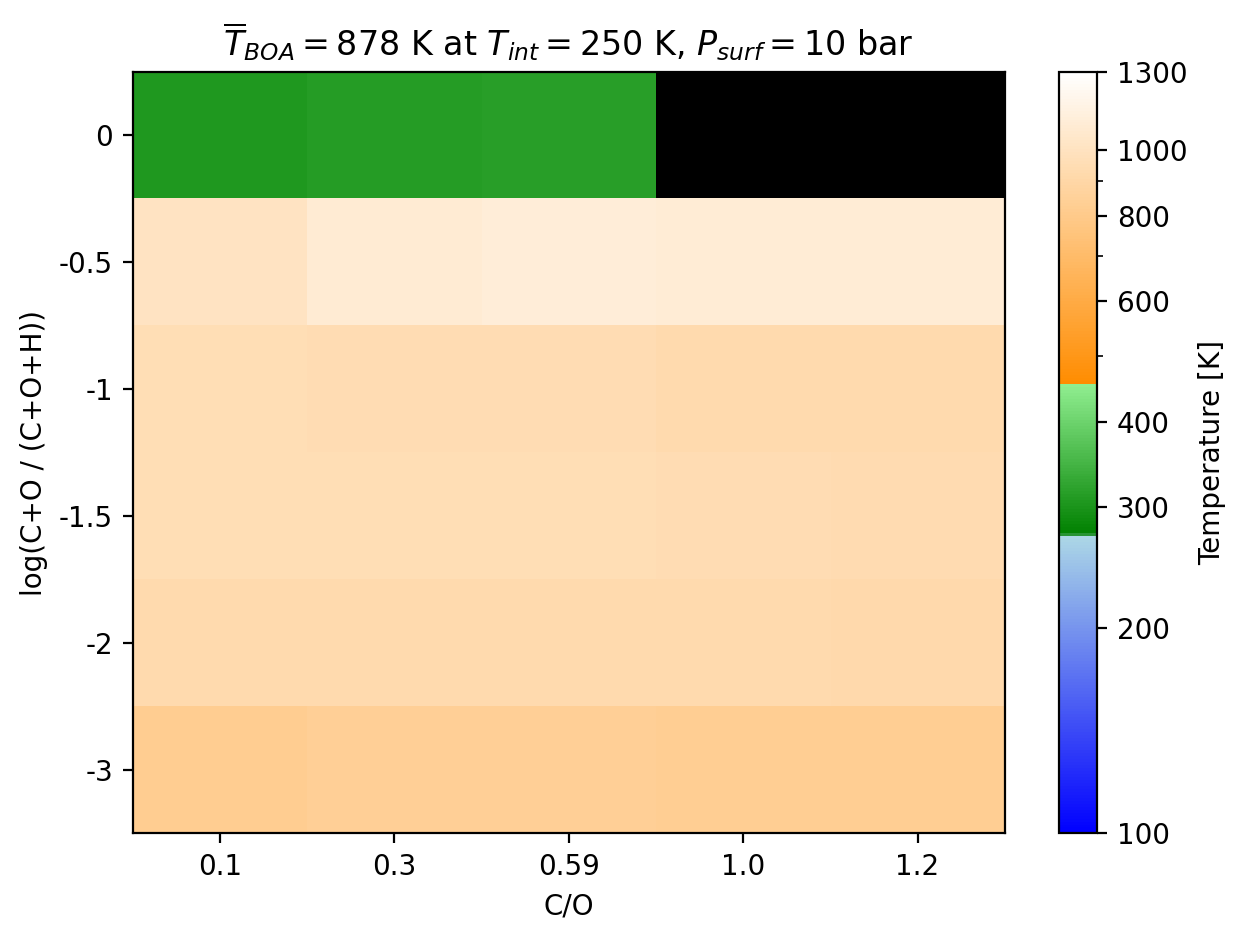

In [123]:
# plot example BOA and TOA matrices
i_temp = 3
i_press = 1

BOAmatrix, TOAmatrix = get_BOA_TOA(i_temp, i_press)
axis = plot_BOA(BOAmatrix)
print(np.nanmin(BOAmatrix), np.nanmax(BOAmatrix))

18.0882 78.6092


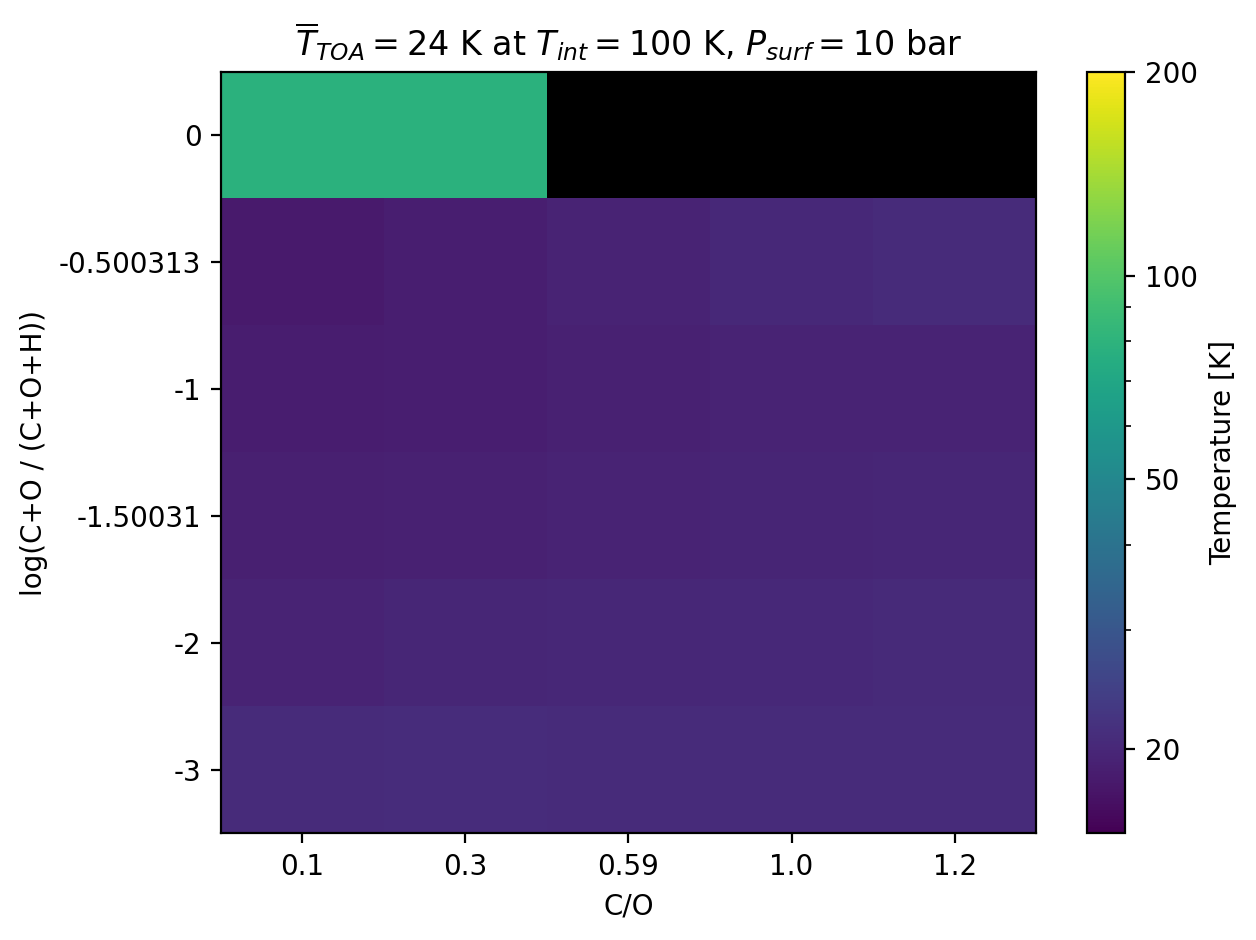

In [95]:
plot_TOA(TOAmatrix)
print(np.nanmin(TOAmatrix), np.nanmax(TOAmatrix))

In [96]:
min_mean_max_BOA = np.zeros((6,2,3))

for i_temp in range(6):
    for i_press in range(2):
        BOAmatrix, TOAmatrix = get_BOA_TOA(i_temp, i_press)
        ax = plot_BOA(BOAmatrix)
        ax.get_figure().savefig(f"images/EqChem/BOA_{Tints[i_temp]}K_{P0s[i_press]/1e6:g}bar.png", dpi=200)
        # clear axis and colorbar
        plt.close(ax.get_figure())

        min_mean_max_BOA[i_temp, i_press, 0] = np.nanmin(BOAmatrix)
        min_mean_max_BOA[i_temp, i_press, 1] = np.nanmean(BOAmatrix)
        min_mean_max_BOA[i_temp, i_press, 2] = np.nanmax(BOAmatrix)

T = 100 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=100_NoCond_CplusO=1e0_CtoO=1.2!
T = 100 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=100_NoCond_CplusO=1e0_CtoO=0.59!
!GGchem did not converge for Earth_P0=1e7_Tint=100_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e7_Tint=100_NoCond_CplusO=1e0_CtoO=1.2!
T = 150 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=150_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e6_Tint=150_NoCond_CplusO=1e0_CtoO=1.2!
T = 150 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=150_NoCond_CplusO=1e0_CtoO=0.59!
!GGchem did not converge for Earth_P0=1e7_Tint=150_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e7_Tint=150_NoCond_CplusO=1e0_CtoO=1.2!
T = 200 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=200_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e6_Tint=200_NoCond_CplusO=1e0_CtoO=1.2!
T = 200

In [97]:
min_mean_max_TOA = np.zeros((4,2,3))

for i_temp in range(4):
    for i_press in range(2):
        BOAmatrix, TOAmatrix = get_BOA_TOA(i_temp, i_press)
        ax = plot_TOA(TOAmatrix)
        ax.get_figure().savefig(f"images/EqChem/TOA_{Tints[i_temp]}K_{P0s[i_press]/1e6:g}bar.png", dpi=200)
        # clear axis and colorbar
        plt.close(ax.get_figure())

        min_mean_max_TOA[i_temp, i_press, 0] = np.nanmin(TOAmatrix)
        min_mean_max_TOA[i_temp, i_press, 1] = np.nanmean(TOAmatrix)
        min_mean_max_TOA[i_temp, i_press, 2] = np.nanmax(TOAmatrix)

T = 100 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=100_NoCond_CplusO=1e0_CtoO=1.2!
T = 100 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=100_NoCond_CplusO=1e0_CtoO=0.59!
!GGchem did not converge for Earth_P0=1e7_Tint=100_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e7_Tint=100_NoCond_CplusO=1e0_CtoO=1.2!
T = 150 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=150_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e6_Tint=150_NoCond_CplusO=1e0_CtoO=1.2!
T = 150 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=150_NoCond_CplusO=1e0_CtoO=0.59!
!GGchem did not converge for Earth_P0=1e7_Tint=150_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e7_Tint=150_NoCond_CplusO=1e0_CtoO=1.2!
T = 200 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=200_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e6_Tint=200_NoCond_CplusO=1e0_CtoO=1.2!
T = 200

In [188]:
# plot other matrices

def get_other(i_temp, i_press, get, dust=False):
    # read TOA and BOA temps for certain T and P with varying h2o and co2
    print('T =', Tints[i_temp], 'K , P =', P0s[i_press]/1e6, 'bar')

    data_matrix = np.empty((len(CplusOs), len(CtoOs)))
    data_matrix[:] = np.nan

    loop_overs = CplusOs

    for i_CtoO in np.arange(len(CtoOs)):
        name, inds, PTs, nHtots, data, atoms, mols, supersats, dusts, mus, conv, n_iter = extract_data(loop_overs, i_P0=i_press, i_Tint=i_temp, i_CtoO=i_CtoO)
        n_tots, atoms, mols, dusts = convert(data, atoms, mols, dusts, nHtots)

        if get == 'n_iter':
            if i_CtoO == 0:
                print(n_iter)
            data_matrix[conv, i_CtoO] = n_iter[conv]
        #elif get == 'conv':
        #    data_matrix[:, i_CtoO] = conv
        elif get == 'dom_surf' or get == 'dominant at surface':
            data_matrix[conv, i_CtoO] = np.argmax(mols[conv,0,:], axis=-1)
        elif get == 'dom' or get == 'dominant':
            data_matrix[conv, i_CtoO] = np.argmax(np.mean(mols[conv,:,:], axis=-2), axis=-1)
        
        else:
            if i_CtoO == 0:
                data_matrix = np.empty((len(CplusOs), len(CtoOs), mus[0].shape[0]))
                data_matrix[:] = np.nan
            
            if get == 'mu' or get == 'mus':
                print(mus.shape)
                data_matrix[conv, i_CtoO] = mus[conv,:]
            elif get == 'nHtot':
                data_matrix[conv, i_CtoO] = nHtots[conv,:]
            elif get == 'n_tot':
                data_matrix[conv, i_CtoO] = n_tots[conv,:]
            elif get in atom_names:
                print(atoms.shape)
                data_matrix[conv, i_CtoO] = atoms[:, :, atom_names == get][conv,:,0]
            elif get in mol_names and not dust:
                data_matrix[conv, i_CtoO] = mols[:, :, mol_names == get][conv,:,0]
            elif get in dust_names and dust:
                data_matrix[conv, i_CtoO] = supersats[:, :, dust_names == get][conv,:,0]
            else:
                raise ValueError('Invalid get value')
    
    return data_matrix

def plot_other(data_matrix, title, cbar_label, vmin=None, vmax=None, log=False, segmented=False, layer=None, display_text=False):

    if not segmented:
        if layer == None or layer == 'mean':
            if log:
                data_matrix = 10**np.nanmean(np.log10(data_matrix), axis=-1)
            else:
                data_matrix = np.nanmean(data_matrix, axis=-1)
        elif layer == 'min':
            data_matrix = np.nanmin(data_matrix, axis=-1)
        elif layer == 'max':
            data_matrix = np.nanmax(data_matrix, axis=-1)
        else:
            data_matrix = data_matrix[:,:,layer]
    
    if log:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None

    if vmin == None:
        vmin = np.nanmin(data_matrix)

    if vmax == None:
        vmax = np.nanmax(data_matrix)

    # build cmaps
    if segmented: # special case for n_iter
        if cbar_label == 'n_iter':
            n = int(vmax - vmin + 1)
            cbar_label = "Number of iterations"
        elif cbar_label == 'dominant' or cbar_label == 'dom':
            n = len(np.unique(data_matrix[~np.isnan(data_matrix)]))
            mol_mask = np.int32(np.unique(data_matrix[~np.isnan(data_matrix)]))
            for i,ind in enumerate( np.unique(data_matrix[~np.isnan(data_matrix)]) ):
                data_matrix[data_matrix == ind] = i
            vmin = 0
            vmax = n
            cbar_label = "Dominant species (mean abundance over layers)"
        elif cbar_label == 'dominant at surface' or cbar_label == 'dom_surf':
            n = len(np.unique(data_matrix[~np.isnan(data_matrix)]))
            mol_mask = np.int32(np.unique(data_matrix[~np.isnan(data_matrix)]))
            for i,ind in enumerate( np.unique(data_matrix[~np.isnan(data_matrix)]) ):
                data_matrix[data_matrix == ind] = i
            vmin = 0
            vmax = n-1
            cbar_label = "Dominant species at surface"
        # build segmented viridis colormap with n colors
        colors = [cmap(i / (n - 1)) for i in range(n)]
        custom_cmap = ListedColormap(colors)
        bounds = vmin + np.arange(n+1) - 0.5
        norm = mpl.colors.BoundaryNorm(bounds, custom_cmap.N)
    else:
        custom_cmap = plt.get_cmap('viridis')
        custom_cmap.set_bad(color='black')

    if norm is None:
        plt.imshow(data_matrix, cmap=custom_cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(data_matrix, cmap=custom_cmap, origin='lower', aspect='auto', norm=norm)
    
    cbar = plt.colorbar(cmap=custom_cmap, label=cbar_label)
    if segmented:
        cbar_ticks = np.arange(vmin, vmax+1)
        cbar.minorticks_off()
        cbar.set_ticks(cbar_ticks)
    
    plt.xticks(np.arange(len(CtoOs)), CtoOs)
    plt.yticks(np.arange(len(CplusOs)), [f'{np.log10(CplusO):.2g}' for CplusO in CplusOs])
    plt.xlabel("C/O")
    plt.ylabel("log(C+O / (C+O+H))")
    plt.title(title)
    plt.tight_layout()

    if display_text:
        if segmented:
            for (j,i),label in np.ndenumerate(data_matrix):
                if cbar_label == "Number of iterations":
                    plt.text(i,j,f'{label:.0f}',ha='center',va='center')
                else:
                    # for plotting dominant species
                    if not np.isnan(label):
                        plt.text(i,j,mol_names[mol_mask][int(label)],ha='center',va='center')
                        # delete colorbar
                        if i == 0 and j == 0:
                            cbar.remove()
        else:
            for (j,i),label in np.ndenumerate(data_matrix):
                plt.text(i,j,f'{label:.1e}',ha='center',va='center')

    return plt.gca()

T = 250 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=250_NoCond_CplusO=1e0_CtoO=1.0!
!GGchem did not converge for Earth_P0=1e7_Tint=250_NoCond_CplusO=1e0_CtoO=1.2!
0.0 22.0


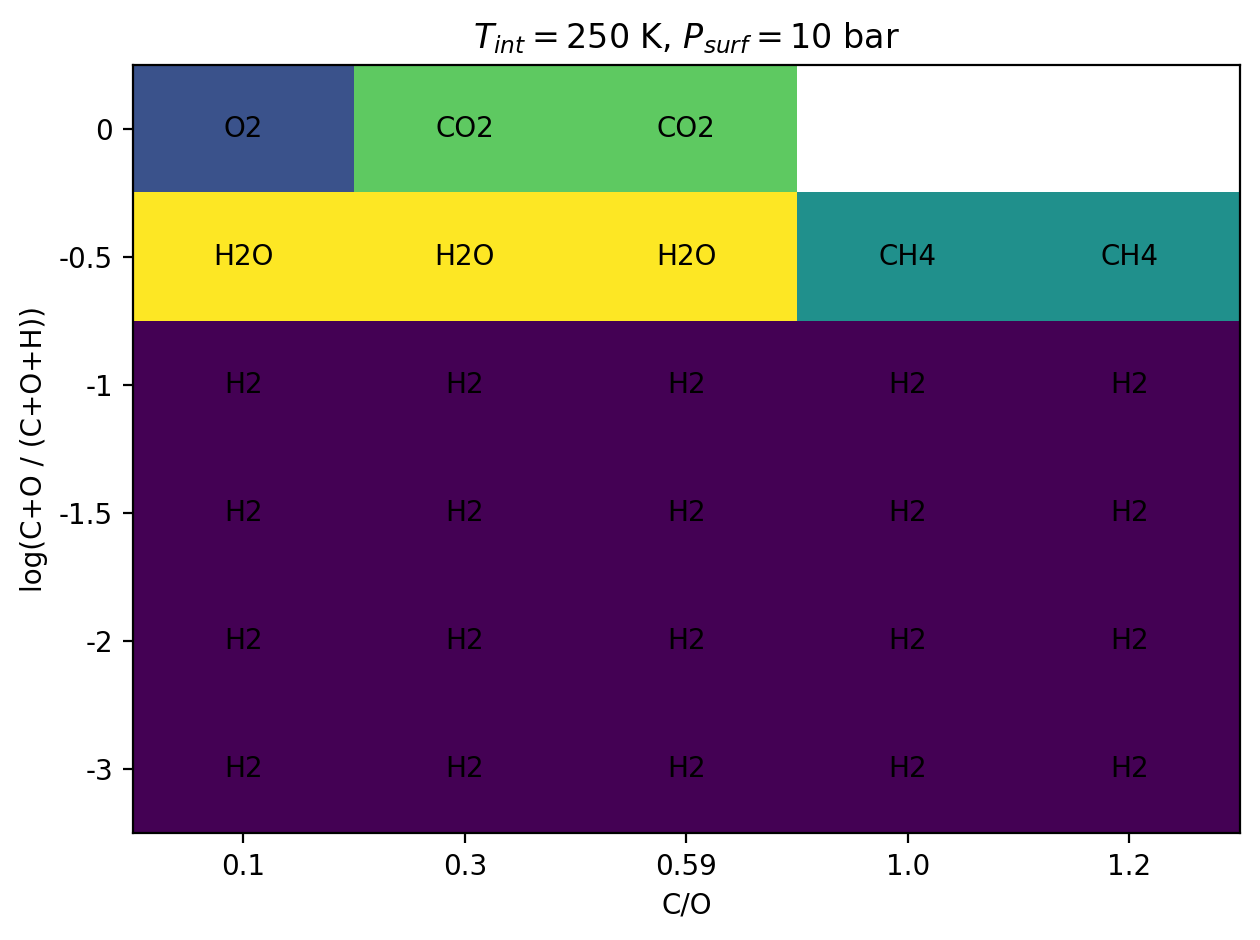

In [191]:
i_temp = 3
i_press = 1
get = 'dom'

# set dust=True for supersaturation
data_matrix = get_other(i_temp, i_press, get=get, dust=False)
print(np.nanmin(data_matrix), np.nanmax(data_matrix))

title = r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar"

# segmented=True for n_iter
# if layer=mean and log=True, the mean is calculated in log space
ax = plot_other(data_matrix, title, get, log=False, segmented=True, vmin=None, vmax=None, layer='max', display_text=True)
